In [1]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import matplotlib.pyplot as plt
import copy


In [2]:

# 初期設定
# Setup seeds
#乱数を生成している？
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [3]:
import sys
sys.path.append('../semantic_segmentation/')

/home/filament/Downloads/semantic_segmentation/data/VOCdevkit/VOC2012/fil_norm_data/taurus_6.npy
/home/filament/Downloads/semantic_segmentation/data/VOCdevkit/VOC2012/filament_taurus_mask_convert/taurus_6.png
val_dataset.__getitem__(0)[0].shape: torch.Size([1, 475, 475])
------------------------------------------------
val_dataset.__getitem__(0)[1]: torch.Size([475, 475])
-------------------------------------------------
val_dataset.__getitem__(0): (tensor([[[ 0.5205,  0.5372,  0.5701,  ..., -0.4191, -0.4070, -0.3412],
         [ 0.5445,  0.5540,  0.5954,  ..., -0.3937, -0.3824, -0.3144],
         [ 0.5777,  0.5777,  0.6287,  ..., -0.3585, -0.3459, -0.2742],
         ...,
         [-1.3207, -1.3591, -1.3869,  ..., -1.8977, -1.8977, -1.8977],
         [-1.3152, -1.3738, -1.3997,  ..., -1.8977, -1.8977, -1.8977],
         [-1.3136, -1.3865, -1.4101,  ..., -1.8977, -1.8977, -1.8977]]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  .

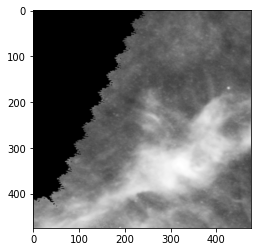

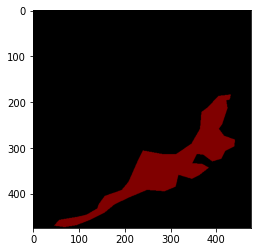

torch.Size([1, 475, 475]) <class 'torch.Tensor'>


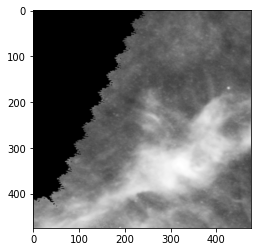

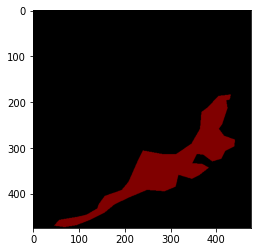

torch.Size([1, 475, 475]) <class 'torch.Tensor'>


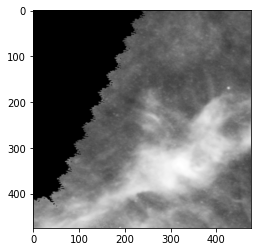

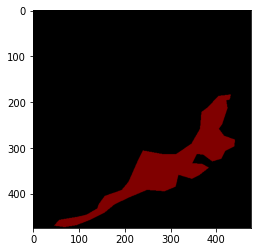

torch.Size([1, 475, 475]) <class 'torch.Tensor'>


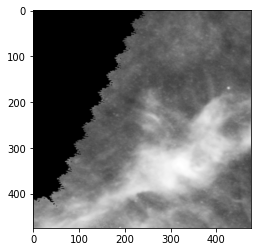

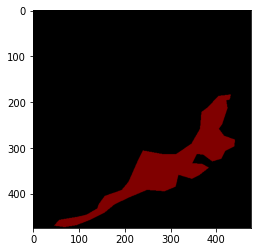

torch.Size([1, 475, 475]) <class 'torch.Tensor'>


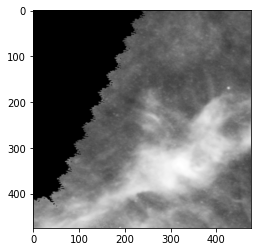

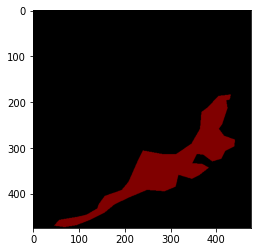

torch.Size([1, 475, 475]) <class 'torch.Tensor'>


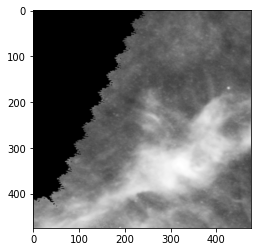

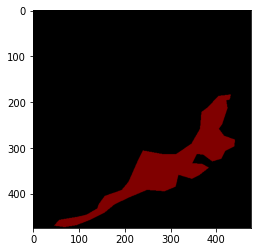

torch.Size([1, 475, 475]) <class 'torch.Tensor'>


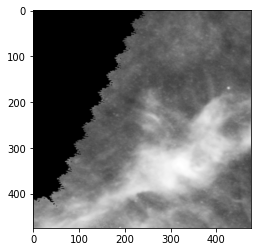

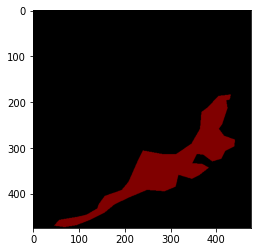

torch.Size([1, 475, 475]) <class 'torch.Tensor'>


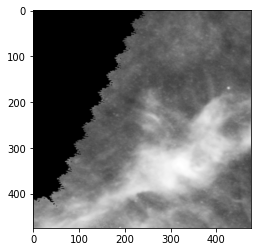

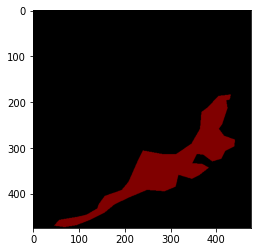

torch.Size([1, 475, 475]) <class 'torch.Tensor'>


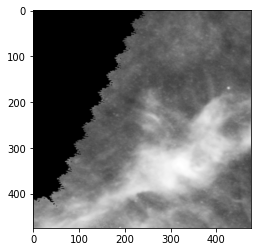

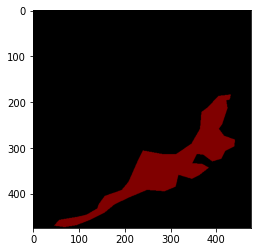

torch.Size([1, 475, 475]) <class 'torch.Tensor'>


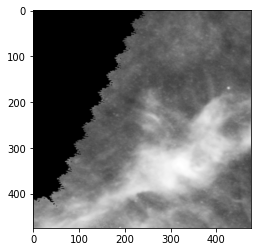

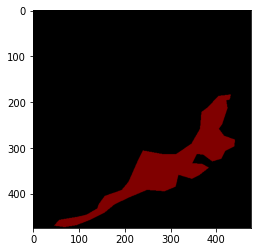

torch.Size([1, 475, 475])


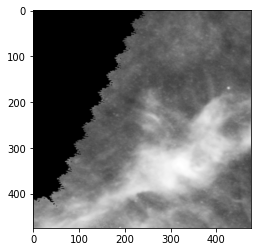

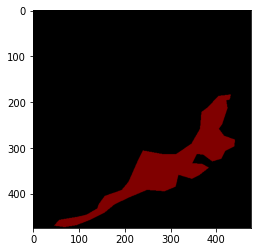

torch.Size([1, 475, 475])


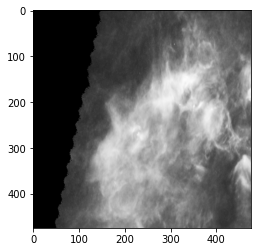

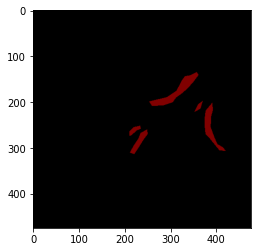

In [4]:
from utils.numpy_dataloader import make_datapath_list,VOCDataset

# ファイルパスリスト作成
rootpath = "../semantic_segmentation/data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

# Dataset作成




# (RGB)の色の平均値と標準偏差
# color_mean = (0.485, 0.456, 0.406) #3ch
# color_std = (0.229, 0.224, 0.225)
color_mean = 0.5 #1ch
color_std = 0.2
input_size = 475

# train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
#     input_size=475, color_mean=color_mean, color_std=color_std))

# val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
#     input_size=475, color_mean=color_mean, color_std=color_std))


train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train",input_size = input_size)

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val",input_size = input_size)

# DataLoader作成
batch_size = 2 #8->4

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}


In [5]:
import glob
from PIL import Image
arr = glob.glob("/home/filament/Downloads/semantic_segmentation/data/VOCdevkit/VOC2012/filament_taurus_datasets_grey_arcnorm_array/*.npy")
anno_arr = glob.glob("/home/filament/Downloads/semantic_segmentation/data/VOCdevkit/VOC2012/filament_taurus_mask_convert/*.png")


In [6]:
a = np.load(arr[0])
a.shape

(475, 475)

In [7]:
a_= np.array(Image.open(anno_arr[0]))
a_.shape

(475, 475)

In [8]:
arr[0]

'/home/filament/Downloads/semantic_segmentation/data/VOCdevkit/VOC2012/filament_taurus_datasets_grey_arcnorm_array/taurus_1.npy'

In [9]:
anno_arr[0]

'/home/filament/Downloads/semantic_segmentation/data/VOCdevkit/VOC2012/filament_taurus_mask_convert/taurus_25.png'

In [10]:
len(train_img_list)

40

In [11]:
len(val_img_list)

5

In [12]:
from utils.pspnet import PSPNet

# ファインチューニングでPSPNetを作成
# ADE20Kデータセットの学習済みモデルを使用、ADE20Kはクラス数が150です
net = PSPNet(n_classes=150)

# ADE20K学習済みパラメータをロード
# net.load_state_dict(state_dict)  #3ch
# net.load_state_dict(state_dict_)   #1ch


#block_configを減らす場合は学習済みパラメータは使わない
# 分類用の畳み込み層を、出力数21のものにつけかえる
n_classes = 2
net.decode_feature.classification = nn.Conv2d(
    in_channels=512, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

net.aux.classification = nn.Conv2d(
    in_channels=256, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

# 付け替えた畳み込み層を初期化する。活性化関数がシグモイド関数なのでXavierを使用する。


def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None:  # バイアス項がある場合
            nn.init.constant_(m.bias, 0.0)


net.decode_feature.classification.apply(weights_init)
net.aux.classification.apply(weights_init)


print('ネットワーク設定完了：学習済みの重みをロードしました')


ネットワーク設定完了：学習済みの重みをロードしました


In [13]:
from utils.UNet import UNet
net = UNet(n_channels = 1, n_classes = 2,input_size = 475 ,bilinear = True)

In [14]:
net.cuda()

UNet(
  (Double_Conv_0): DoubleConv(
    (conv_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (relu): ReLU(inplace=True)
  )
  (Down_1): Down(
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Double_Conv): DoubleConv(
      (conv_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (conv_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
  )
  (Down_2): Down(
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Double_Conv): DoubleConv(
      (conv_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (conv_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
  )
  (Down_3): Down(
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

In [15]:
summary(net,(1,475,475))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 473, 473]             576
              ReLU-2         [-1, 64, 473, 473]               0
            Conv2d-3         [-1, 64, 471, 471]          36,864
              ReLU-4         [-1, 64, 471, 471]               0
        DoubleConv-5         [-1, 64, 471, 471]               0
         MaxPool2d-6         [-1, 64, 235, 235]               0
            Conv2d-7        [-1, 128, 233, 233]          73,728
              ReLU-8        [-1, 128, 233, 233]               0
            Conv2d-9        [-1, 128, 231, 231]         147,456
             ReLU-10        [-1, 128, 231, 231]               0
       DoubleConv-11        [-1, 128, 231, 231]               0
             Down-12        [-1, 128, 231, 231]               0
        MaxPool2d-13        [-1, 128, 115, 115]               0
           Conv2d-14        [-1, 256, 1

In [16]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)


UNet(
  (Double_Conv_0): DoubleConv(
    (conv_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (relu): ReLU(inplace=True)
  )
  (Down_1): Down(
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Double_Conv): DoubleConv(
      (conv_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (conv_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
  )
  (Down_2): Down(
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Double_Conv): DoubleConv(
      (conv_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (conv_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
  )
  (Down_3): Down(
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

In [17]:

# 損失関数の設定
class PSPLoss(nn.Module):
    """PSPNetの損失関数のクラスです。"""

    def __init__(self, aux_weight=0.4):
        super(PSPLoss, self).__init__()
        self.aux_weight = aux_weight  # aux_lossの重み

    def forward(self, outputs, targets):
        """
        損失関数の計算。

        Parameters
        ----------
        outputs : PSPNetの出力(tuple)
            (output=torch.Size([num_batch, 21, 475, 475]), output_aux=torch.Size([num_batch, 21, 475, 475]))。

        targets : [num_batch, 475, 475]
            正解のアノテーション情報

        Returns
        -------
        loss : テンソル
            損失の値
        """

        loss = F.cross_entropy(outputs[0], targets, reduction='mean')
        loss_aux = F.cross_entropy(outputs[1], targets, reduction='mean')

        return loss+self.aux_weight*loss_aux
    
class UNetLoss(nn.Module):
    """PSPNetの損失関数のクラスです。"""

    def __init__(self):  # aux_weight=0.4
        super(UNetLoss, self).__init__()
        # self.aux_weight = aux_weight  # aux_lossの重み

    def forward(self, outputs, targets):
        """
        損失関数の計算。

        Parameters
        ----------
        outputs : PSPNetの出力(tuple)
            (output=torch.Size([num_batch, 21, 475, 475]), output_aux=torch.Size([num_batch, 21, 475, 475]))。

        targets : [num_batch, 475, 475]
            正解のアノテーション情報

        Returns
        -------
        loss : テンソル
            損失の値
        """

        # loss = F.cross_entropy(outputs[0], targets, reduction='mean')
        # loss_aux = F.cross_entropy(outputs[1], targets, reduction='mean')
        loss = F.cross_entropy(outputs, targets, reduction='mean')

        return loss


criterion = UNetLoss()







In [28]:
# ファインチューニングなので、学習率は小さく

# optimizer = optim.SGD([
#     {'params': net.feature_conv.parameters(), 'lr': 1.5},
#     {'params': net.feature_res_1.parameters(), 'lr': 1.5},
#     {'params': net.feature_res_2.parameters(), 'lr': 1.5},
#     {'params': net.feature_dilated_res_1.parameters(), 'lr': 1.5},
#     {'params': net.feature_dilated_res_2.parameters(), 'lr': 1.5},
#     {'params': net.pyramid_pooling.parameters(), 'lr': 1.5},
#     {'params': net.decode_feature.parameters(), 'lr': 1.5},
#     {'params': net.aux.parameters(), 'lr': 1.5},
# ], momentum=0.9, weight_decay=0.0001)


optimizer = optim.Adam([
    {"params" : net.Double_Conv_0.parameters(), "lr": 0.1},
    {"params" : net.Down_1.parameters(), "lr": 0.1},
    {"params" : net.Down_2.parameters(), "lr": 0.1},
    {"params" : net.Down_3.parameters(), "lr": 0.1},
    {"params" : net.Down_4.parameters(), "lr": 0.1},
    
    {"params" : net.Up_1.parameters(), "lr": 0.1},
    {"params" : net.Double_Conv_1.parameters(), "lr": 0.1},
    
    {"params" : net.Up_2.parameters(), "lr": 0.1},
    {"params" : net.Double_Conv_2.parameters(), "lr": 0.1},
    
    {"params" : net.Up_3.parameters(), "lr": 0.1},
    {"params" : net.Double_Conv_3.parameters(), "lr": 0.1},
    
    {"params" : net.Up_4.parameters(), "lr": 0.1},
    {"params" : net.Double_Conv_4.parameters(), "lr": 0.1},
    
    {"params" : net.output.parameters(), "lr": 0.1},


], weight_decay = 0.0001)

#lr_1 =1e-3,lr_2=1e-3,lr_3=1e-3,lr_4=1e-3,lr_5=1e-3,lr_6=1e-3,lr_7=1e-2,lr_8=1e-2

##########################
# def leaning_rate(lr_1 =1e-3,lr_2=1e-3,lr_3=1e-3,lr_4=1e-3,lr_5=1e-3,lr_6=1e-3,lr_7=1e-2,lr_8=1e-2):
#     optimizer = optim.SGD([
#         {'params': net.feature_conv.parameters(), 'lr': lr_1},
#         {'params': net.feature_res_1.parameters(), 'lr': lr_2},
#         {'params': net.feature_res_2.parameters(), 'lr': lr_3},
#         {'params': net.feature_dilated_res_1.parameters(), 'lr': lr_4},
#         {'params': net.feature_dilated_res_2.parameters(), 'lr': lr_5},
#         {'params': net.pyramid_pooling.parameters(), 'lr': lr_6},
#         {'params': net.decode_feature.parameters(), 'lr': lr_7},
#         {'params': net.aux.parameters(), 'lr': lr_8},
#     ], momentum=0.9, weight_decay=0.0001)



# optimizer = optim.Adam([
#     {'params': net.feature_conv.parameters(), 'lr': 1e-3},
#     {'params': net.feature_res_1.parameters(), 'lr': 1e-3},
#     {'params': net.feature_res_2.parameters(), 'lr': 1e-3},
#     {'params': net.feature_dilated_res_1.parameters(), 'lr': 1e-3},
#     {'params': net.feature_dilated_res_2.parameters(), 'lr': 1e-3},
#     {'params': net.pyramid_pooling.parameters(), 'lr': 1e-3},
#     {'params': net.decode_feature.parameters(), 'lr': 1e-2},
#     {'params': net.aux.parameters(), 'lr': 1e-2},
# ], weight_decay=0.0001)


# スケジューラーの設定
def lambda_epoch(epoch):
    max_epoch = 30 #30
    return math.pow((1-epoch/max_epoch), 0.995)  #0.9


scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_epoch)


AttributeError: 'UNet' object has no attribute 'feature_conv'

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, path, patience=7, verbose=False, delta=0, trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
img = next(iter(dataloaders_dict["train"]))[0]

In [ ]:
img[0].shape

In [ ]:
net.to("cpu")

In [23]:
img[1].shape

torch.Size([1, 475, 475])

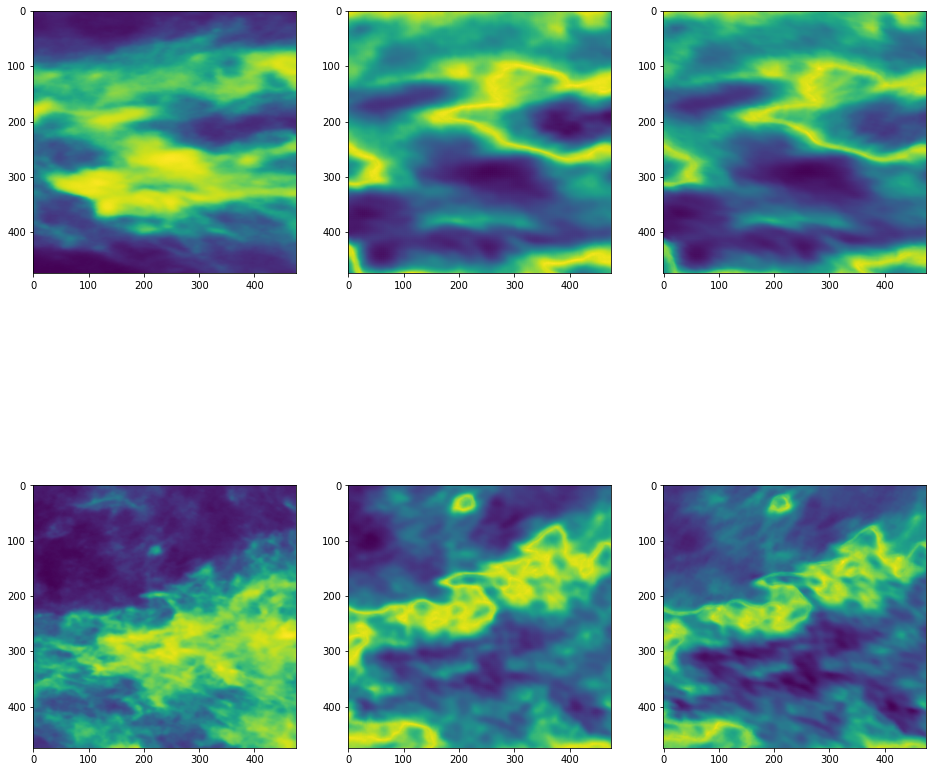

In [24]:
fig,ax = plt.subplots(2,3,figsize = (16,16))
ax[0,0].imshow(img[0][0].detach().numpy())

ax[0,1].imshow(net(img)[0][0].detach().numpy())
ax[0,2].imshow(net(img)[0][1].detach().numpy())


ax[1,0].imshow(img[1][0].detach().numpy())
ax[1,1].imshow(net(img)[1][0].detach().numpy())
ax[1,2].imshow(net(img)[1][1].detach().numpy())

In [25]:
train_loss_list = []
train_epoch_loss = []
val_loss_list = []

def train_model(net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("device:", device)
    
    net.to(device)
    
    torch.backends.cudnn.benchmark = True
    
    num_train_imgs = len(dataloaders_dict["train"].dataset)
    num_val_imgs = len(dataloaders_dict["val"].dataset)
    batch_size = dataloaders_dict["train"].batch_size
    
    iteration = 1
    logs = []
    
    for epoch in range(num_epochs):
        
        t_epoch_start = time.time()
        t_iter_start = time.time()
        
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0
        
        print('-------------')
        print("Epoch : {}/{}".format(epoch+1, num_epochs))
        print('-------------')
        
        for phase in ["train","val"]:
            if phase = "train":
                net.train()
                scheduler.step()
                optimizer.zero_grad()
                print("(train)")
                
                
    

SyntaxError: invalid syntax (3435514934.py, line 5)

In [26]:
# モデルを学習させる関数を作成
train_loss_list = []
train_epoch_loss = []
val_loss_list = []

def train_model(net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloaders_dict["train"].dataset)
    num_val_imgs = len(dataloaders_dict["val"].dataset)
    batch_size = dataloaders_dict["train"].batch_size
    
    #early stopping
    early_stopping = EarlyStopping(patience=10, verbose=True, path='earlystopping.pth')
    

    # イテレーションカウンタをセット
    iteration = 1
    logs = []

    # multiple minibatch
    batch_multiplier = 3

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()
        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
                scheduler.step()  # 最適化schedulerの更新
                optimizer.zero_grad()
                print('（train）')

            else:
                if((epoch+1) % 5 == 0):
                    net.eval()   # モデルを検証モードに
                    print('-------------')
                    print('（val）')
                else:
                    # 検証は5回に1回だけ行う
                    continue

            # データローダーからminibatchずつ取り出すループ
            count = 0  # multiple minibatch
            for imges, anno_class_imges in dataloaders_dict[phase]:
                # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
                if imges.size()[0] == 1:
                    continue

                # GPUが使えるならGPUにデータを送る
                imges = imges.to(device)
                anno_class_imges = anno_class_imges.to(device)

                
                # multiple minibatchでのパラメータの更新
                if (phase == 'train') and (count == 0):
                    optimizer.step()
                    optimizer.zero_grad()
                    count = batch_multiplier

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(imges)
                    # print(len(outputs))
                    loss = criterion(
                        outputs, anno_class_imges.long()) / batch_multiplier
                    # print(anno_class_imges.long())
                    


                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()  # 勾配の計算
                        count -= 1  # multiple minibatch

                        # if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                        if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            if (iteration % 1000 == 0):
                                
                                print('イテレーション {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                    iteration, loss.item()/batch_size*batch_multiplier, duration))
                            t_iter_start = time.time()
                            train_loss_list.append(loss.item()/batch_size*batch_multiplier)

                        epoch_train_loss += loss.item() * batch_multiplier
                        iteration += 1

                    # 検証時
                    else:
                        epoch_val_loss += loss.item() * batch_multiplier

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss/num_train_imgs, epoch_val_loss/num_val_imgs))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()
        train_loss_list.append(epoch_train_loss/num_train_imgs)
        train_epoch_loss.append(epoch_train_loss/num_train_imgs)
        val_loss_list.append(epoch_val_loss/num_val_imgs)


        # ログを保存
        log_epoch = {'epoch': epoch+1, 'train_loss': epoch_train_loss /
                     num_train_imgs, 'val_loss': epoch_val_loss/num_val_imgs}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("log_output.csv")
        
        early_stopping(epoch_val_loss, net)
    
#         if early_stopping.early_stop:
#             train_bbbb = np.concatenate(train_bbbb, axis=0)
#             #f.write(train_bbbb.shape, val_bbbb_.shape)
#             print(train_bbbb.shape, val_bbbb_.shape)

#             f.write('Early_Stopping\n')
#             print('Early_Stopping')
#             break

    # 最後のネットワークを保存する
    # torch.save(net.state_dict(), '../semantic_segmentation/weights/500epoch_21class_1ch_sch0.995_lr*3_3463_img475_batch4_SGD/pspnet50_' +
    #            str(epoch+1) + '_2class_1ch_trans_sch0.995_lr*3_3463_img475_batch4_SGD_net.pth')
    torch.save(net.state_dict(), '../semantic_segmentation/weights/np_array_weight/' +
               str(epoch+1) + '_net.pth')
    # torch.save(net.state_dict(), '../semantic_segmentation/weights/remake/pspnet50_' + str(epoch+1) + '_21class_3ch_transless_img475_batch4_lr0.995_netaaaaaaaaaaaaaaaaaaaaaaaa.pth')

In [27]:
# 学習・検証を実行する
num_epochs = 30
train_model(net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs=num_epochs)


使用デバイス： cuda:0
-------------
Epoch 1/30
-------------
（train）


/home/filament/.pyenv/versions/3.7.11/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


-------------
epoch 1 || Epoch_TRAIN_Loss:41109335578827111483301691392.0000 ||Epoch_VAL_Loss:0.0000
timer:  2.5763 sec.
Validation loss decreased (inf --> 0.000000).  Saving model ...
-------------
Epoch 2/30
-------------
（train）
-------------
epoch 2 || Epoch_TRAIN_Loss:59037129295971574530044854272.0000 ||Epoch_VAL_Loss:0.0000
timer:  1.8334 sec.
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
-------------
Epoch 3/30
-------------
（train）
-------------
epoch 3 || Epoch_TRAIN_Loss:59927643504946661699484647424.0000 ||Epoch_VAL_Loss:0.0000
timer:  1.8318 sec.
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
-------------
Epoch 4/30
-------------
（train）
-------------
epoch 4 || Epoch_TRAIN_Loss:60435244435812123560973959168.0000 ||Epoch_VAL_Loss:0.0000
timer:  1.8408 sec.
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
-------------
Epoch 5/30
-------------
（train）
-------------
（val）
-------------
epoch 5 || Epoch_TRAIN_

KeyboardInterrupt: 

In [22]:
val_loss_list_=val_loss_list
# val_loss_list_[val_loss_list_>=0.5]=0.5
val_loss_list__ = [i for i in val_loss_list if i > 0]

In [23]:
val_loss_list__ = [i for i in val_loss_list__ if i < 1]

NameError: name 'ls_' is not defined

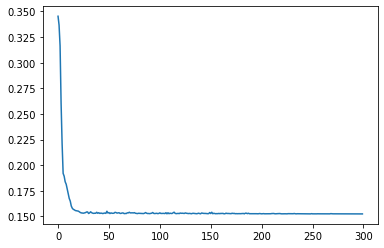

In [24]:
plt.plot(range(len(train_epoch_loss)), train_epoch_loss, label="Train")
plt.plot(ls_, val_loss_list__, label="Test")
plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show()

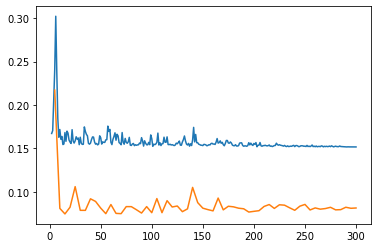

In [36]:
df = pd.read_csv("log_output.csv")

ls_ = []
i = 1
while i <= 300:
    if i % 5 == 0:
        ls_.append(i)
    i+=1    
    
epoch_ls = df["epoch"].tolist()
train_loss = df["train_loss"].tolist()
val_loss = df["val_loss"].tolist()
val_loss = [i for i in val_loss if i != 0]
plt.plot(epoch_ls[1:], train_loss[1:])
plt.plot(ls_, val_loss)